# Modelo Matemática - Árvore de Steiner



    definição do modelo goes here.



## lendo dados

In [13]:
from classes import Network, MulticastGroup
from multicastpacking import MulticastPacking, solver
import reader

#instancen of the problem
file = "../../../MPP_instances/n120/b120_1.brite"

# listofopt = "..."

links = reader.get_network (file)
net = Network (links, nodes = 120)


mgroups = [MulticastGroup (g) for g in reader.get_groups (file) ]

problem = MulticastPacking (net, mgroups)

KSIZE = len(problem.groups)+1
NODES = net.nodes+1

## Definição de Variáveis

In [5]:
def create_variable (m, k, var_x, var_y):
    for link in net.links:
        y=link[0],link[1]
        var_y[y]=m.addVar(vtype=GRB.BINARY, obj=1, name=str(y))
        y=link[1],link[0]
        var_y[y]=m.addVar(vtype=GRB.BINARY, obj=1, name=str(y))

    m.update ()

    for d in problem.groups[k-1].members:
        for link in net.links:
            y=link[0],link[1],d
            var_x[y]=m.addVar(vtype=GRB.BINARY, obj=1, name=str(y))
            y=link[1],link[0],d
            var_x[y]=m.addVar(vtype=GRB.BINARY, obj=1, name=str(y))

    m.update ()

## Restrições de Fluxo

In [6]:
## fluxo 1

#fluxo saindo da fonte sk para o destino d no grupo K

def flow1 (m, k, var_x, var_y):
    for d in problem.groups[k-1].members:
        sk = problem.groups[k-1].source
        _name='flow1',d
        m.addConstr (
            quicksum ( var_x[x] for x in tuplelist (var_x).select ('*',sk,d) )
            -
            quicksum ( var_x[x] for x in tuplelist (var_x).select (sk,'*',d) )
            == -1,
            name=str(_name)
        )

    m.update ()


#fluxo chegando no destino d no grupo K
def flow2 (m, k, var_x, var_y):
    for d in problem.groups[k-1].members:
        sk = problem.groups[k-1].source
        _name='flow2',d
        m.addConstr (
            quicksum (
                var_x[x] for x in tuplelist (var_x).select ('*',d,d)
            )
            -
            quicksum (
                var_x[x] for x in tuplelist (var_x).select (d,'*',d)
            )
            == 1,
            name=str(_name)
        )

    m.update ()

# conservação de fluxo
def flow3 (m, k, var_x, var_y):
    for d in problem.groups[k-1].members:
        for j in xrange(1,NODES):
            sk = problem.groups[k-1].source
            _name='flow3',d,j   
            m.addConstr (
                quicksum(
                    var_x[x] for x in tuplelist (var_x).select ('*',j,d) 
                    if x[1] not in [sk, d]
                )
                -
                quicksum(
                    var_x[x] for x in tuplelist (var_x).select (j,'*',d) 
                    if x[0] not in [sk, d]
                )
                == 0,
                name=str(_name)
            )            

    m.update ()

## Marcar aresta usada

In [7]:

def set_edge (m, k, var_x, var_y):
    for d in problem.groups[k-1].members:
        for link in net.links:
            x=link[0],link[1],d
            y=link[0],link[1]
            _name='mark',link[0],link[1],d
            m.addConstr ( var_x[x] <= var_y[y], 
                name=str(_name)
            )            
            x=link[1],link[0],d
            y=link[1],link[0]
            _name='mark',link[1],link[0],d
            m.addConstr ( var_x[x] <= var_y[y], 
                name=str(_name)
            )

    m.update ()

## Função Objetivo - Custo

In [54]:

def objective_custo (m, var_y, net):
    m.setObjective (
        quicksum (
            var_y[(y[0],y[1])] * net.links[y][0] for y in net.links.keys ()
        )
        +
        quicksum (
            var_y[(y[1],y[0])] * net.links[y][0] for y in net.links.keys ()
        )
    )

## Função Objetivo = Número de Links

In [9]:

def objective_links (m, var_y):
    m.setObjective (
        quicksum (
            var_y[y] for y in tuplelist(var_y)
        )
    )

## Modelo por Número de Links

In [62]:
from gurobipy import *

m = Model ('Steiner Tree') #definindo objetov Model do gurobi

var_y = {} #variável que marca arestas usadas
var_x = {} #variável que controla o fluxo

k = 1  # escolhendo árvore a ser optimizada

create_variable (m, k, var_x, var_y)
flow1 (m, k, var_x, var_y)
flow2 (m, k, var_x, var_y)
flow3 (m, k, var_x, var_y)
set_edge (m, k, var_x, var_y)

objective_links (m, var_y)

In [63]:
m.optimize ()

Optimize a model with 7826 rows, 6720 columns and 24960 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 1e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+00]
Found heuristic solution: objective 362
Presolve removed 44 rows and 18 columns
Presolve time: 0.05s
Presolved: 7782 rows, 6702 columns, 24900 nonzeros
Variable types: 0 continuous, 6702 integer (6702 binary)

Root relaxation: objective 2.200000e+01, 800 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      22.0000000   22.00000  0.00%     -    0s

Explored 0 nodes (800 simplex iterations) in 0.12 seconds
Thread count was 2 (of 4 available processors)

Optimal solution found (tolerance 1.00e-04)
Best objective 2.200000000000e+01, best bound 2.200000000000e+01, gap 0.0%


### Código para Gerar dot da árvore

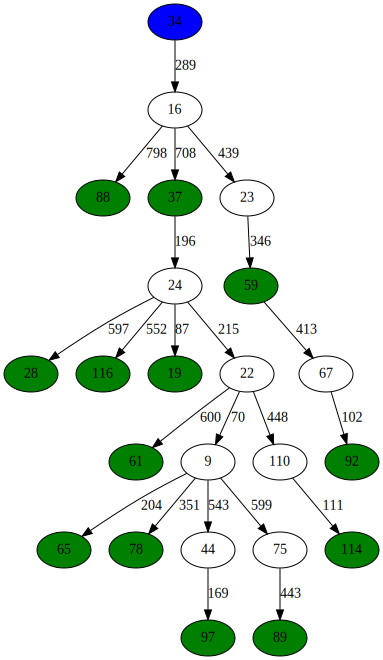

In [64]:
from graphviz import Digraph

g = Digraph ()

kid = k

#style of nodes (sk, Dk)
for d in problem.groups[kid-1].members:
    g.node (str (d), style='filled', fillcolor='green')

sk = problem.groups[kid-1].source
g.node (str(sk), style='filled', fillcolor='blue')

cost = 0.0
for i in var_y:
    name=var_y[i].getAttr ('varname')
    v = m.getVarByName (str(i))    
    l = i if i in net.links else (i[1],i[0]) #creating the right link to access properties
    if v.getAttr('X') == 1:
        g.edge ( str(i[0]) ,str(i[1]), str(net.properties(l)[0]) )
        cost = cost + net.properties(l)[0]

g

## Modelo por Custo

In [55]:
from gurobipy import *

m2 = Model ('Steiner Tree') #definindo objetov Model do gurobi

var_y_ = {} #variável que marca arestas usadas
var_x_ = {} #variável que controla o fluxo

k = 1  # escolhendo árvore a ser optimizada

create_variable (m2, k, var_x_, var_y_)
flow1 (m2, k, var_x_, var_y_)
flow2 (m2, k, var_x_, var_y_)
flow3 (m2, k, var_x_, var_y_)
set_edge (m2, k, var_x_, var_y_)

objective_custo (m2, var_y_, net)

In [56]:
m2.optimize ()

Optimize a model with 7826 rows, 6720 columns and 24960 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 1e+00]
  Objective range [2e+01, 1e+03]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+00]
Found heuristic solution: objective 126495
Presolve removed 44 rows and 18 columns
Presolve time: 0.05s
Presolved: 7782 rows, 6702 columns, 24900 nonzeros
Variable types: 0 continuous, 6702 integer (6702 binary)

Root relaxation: objective 7.026000e+03, 1901 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7026.0000000 7026.00000  0.00%     -    0s

Explored 0 nodes (1901 simplex iterations) in 0.14 seconds
Thread count was 2 (of 4 available processors)

Optimal solution found (tolerance 1.00e-04)
Best objective 7.026000000000e+03, best bound 7.026000000000e+03, gap 0.0%


### Código para Gerar dot da árvore

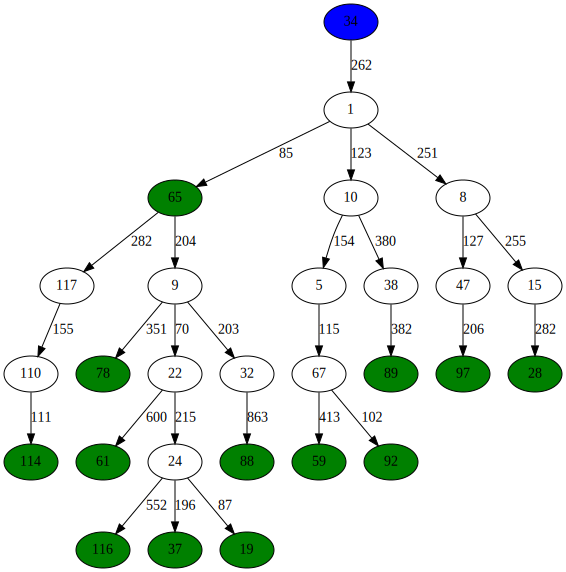

In [61]:
from graphviz import Digraph

g = Digraph ()

kid = k

#style of nodes (sk, Dk)
for d in problem.groups[kid-1].members:
    g.node (str (d), style='filled', fillcolor='green')

sk = problem.groups[kid-1].source
g.node (str(sk), style='filled', fillcolor='blue')

for i in var_y_:
    name=var_y_[i].getAttr ('varname')
    v = m2.getVarByName (str(i))    
    l = i if i in net.links else (i[1],i[0]) #creating the right link to access properties
    if v.getAttr('X') == 1:
        g.edge ( str(i[0]) ,str(i[1]), str(net.properties(l)[0]) )
        

g

In [67]:
# modelo m2 é o valor que reduz o custo da solução

print {'ModelCost':m2.ObjVal, 'ModelLinks':cost}

{'ModelLinks': 8280.0, 'ModelCost': 7026.0}
